<a href="https://colab.research.google.com/github/MennaEzzelarab/teeth-classification/blob/master/week2_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create a folder on Drive to store the unzipped dataset
!mkdir -p "/content/drive/MyDrive/Teeth_Dataset_Unzipped"

# Unzip directly to that folder on Drive
!unzip "/content/drive/MyDrive/Teeth DataSet.zip" -d "/content/drive/MyDrive/Teeth_Dataset_Unzipped"

In [6]:
import shutil

# List everything in Testing
for item in os.listdir(TEST_DIR):
    path = os.path.join(TEST_DIR, item)

    # Delete files
    if os.path.isfile(path):
        os.remove(path)
        print(f"Deleted file: {path}")

    # Delete unrelated folders
    elif os.path.isdir(path):
        # Only delete if it's NOT one of the 7 class folders
        if item not in ['CaS','CoS','Gum','MC','OC','OLP','OT']:
            shutil.rmtree(path)
            print(f"Deleted folder: {path}")

# Verify remaining contents
print("Remaining folders in Testing:", os.listdir(TEST_DIR))

Deleted folder: /content/drive/MyDrive/Teeth_Dataset_Unzipped/Teeth_Dataset/Testing/outputs
Deleted folder: /content/drive/MyDrive/Teeth_Dataset_Unzipped/Teeth_Dataset/Testing/output
Deleted folder: /content/drive/MyDrive/Teeth_Dataset_Unzipped/Teeth_Dataset/Testing/out
Remaining folders in Testing: ['OC', 'Gum', 'CoS', 'OT', 'CaS', 'MC', 'OLP']


Imports

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Configuration

In [3]:
IMG_SIZE = (224, 224) # MobileNetV2 expects 224x224
BATCH_SIZE = 32
EPOCHS_HEAD = 10
EPOCHS_FINE = 20
LEARNING_RATE = 1e-4

# Data Loading

In [4]:
BASE_DIR = '/content/drive/MyDrive/Teeth_Dataset_Unzipped/Teeth_Dataset'
TRAIN_DIR = os.path.join(BASE_DIR, 'Training')
VALID_DIR = os.path.join(BASE_DIR, 'Validation')
TEST_DIR = os.path.join(BASE_DIR, 'Testing')
OUTPUT_DIR = '/content/drive/MyDrive/teeth_classification/outputs'

In [8]:
os.makedirs(os.path.join(OUTPUT_DIR, 'figures/week2'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'models/week2'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'results/week2'), exist_ok=True)
print("🔍 Checking GPU availability...")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU is available: {gpus}")
else:
    print("⚠️ WARNING: No GPU detected! Training will be slow.")

🔍 Checking GPU availability...
✅ GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
print("\n📂 Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='int'
)
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print(f"Classes found: {class_names}")
val_ds = tf.keras.utils.image_dataset_from_directory(
    VALID_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='int'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='int'
)


📂 Loading datasets...
Found 3087 files belonging to 7 classes.
Classes found: ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


Class Weights

In [10]:
print("\n⚖️ Computing class weights...")
y_train = []
for _, labels in train_ds:
    y_train.extend(labels.numpy())
y_train = np.array(y_train)
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_vals))
print(f"Class Weights: {class_weights}")


⚖️ Computing class weights...
Class Weights: {0: np.float64(0.91875), 1: np.float64(0.98), 2: np.float64(1.225), 3: np.float64(0.8166666666666667), 4: np.float64(1.3611111111111112), 5: np.float64(0.8166666666666667), 6: np.float64(1.1221374045801527)}


Data Pipeline

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Building Transfer Model

In [13]:
def build_transfer_model(input_shape, num_classes):
    # 1. Base Model (Frozen)
    base_model = applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False # Freeze base model
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = applications.mobilenet_v2.preprocess_input(x) # IMPORTANT: specific preprocessing
    x = base_model(x, training=False)

    # 2. Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs, name="MobileNetV2_Transfer")
    return model, base_model
model, base_model = build_transfer_model(IMG_SIZE + (3,), NUM_CLASSES)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "MobileNetV2_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training

Phase 1: Training Head

In [14]:
print("\n🚀 Phase 1: Training Classification Head...")
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(OUTPUT_DIR, 'models/week2/mobilenetv2_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_HEAD,
    callbacks=callbacks,
    class_weight=class_weights
)


🚀 Phase 1: Training Classification Head...
Epoch 1/10
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1734 - loss: 2.3217
Epoch 1: val_accuracy improved from -inf to 0.43774, saving model to /content/drive/MyDrive/teeth_classification/outputs/models/week2/mobilenetv2_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 141ms/step - accuracy: 0.1745 - loss: 2.3165 - val_accuracy: 0.4377 - val_loss: 1.5522 - learning_rate: 1.0000e-04
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3425 - loss: 1.7025
Epoch 2: val_accuracy improved from 0.43774 to 0.53016, saving model to /content/drive/MyDrive/teeth_classification/outputs/models/week2/mobilenetv2_best.keras
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.3427 - loss: 1.7018 - val_accuracy: 0.5302 - val_loss: 1.3667 - learning_rate: 1.0000e-04
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4217 - loss: 1.5109
Epoch 3: val_accuracy improved from 0.53016 to 0.58560, saving model to /content/drive/MyDrive

Training Phase 2: Fine-Tuning

In [15]:
print("\n🔓 Phase 2: Fine-Tuning Base Model...")
base_model.trainable = True # Unfreeze
# Fine-tune only the top layers of the base model (optional, but safer)
# Let's verify how many layers are in the base model
print(f"Number of layers in the base model: {len(base_model.layers)}")
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
# Recompile with very low learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5), # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Continue training
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINE,
    callbacks=callbacks,
    class_weight=class_weights
)


🔓 Phase 2: Fine-Tuning Base Model...
Number of layers in the base model: 154
Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3682 - loss: 1.6782
Epoch 1: val_accuracy did not improve from 0.72082
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.3685 - loss: 1.6771 - val_accuracy: 0.6809 - val_loss: 0.9249 - learning_rate: 1.0000e-05
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4882 - loss: 1.3564
Epoch 2: val_accuracy did not improve from 0.72082
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.4883 - loss: 1.3561 - val_accuracy: 0.6508 - val_loss: 0.9898 - learning_rate: 1.0000e-05
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5429 - loss: 1.2499
Epoch 3: val_accuracy did not improve from 0.72082
97/97 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.5429 - loss: 1.2496 - val_accuracy: 0.6518 - val_loss: 0.9905 - learning_rate: 1.0000e-05
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5866 - loss

# Plotting

✅ Training curves saved.


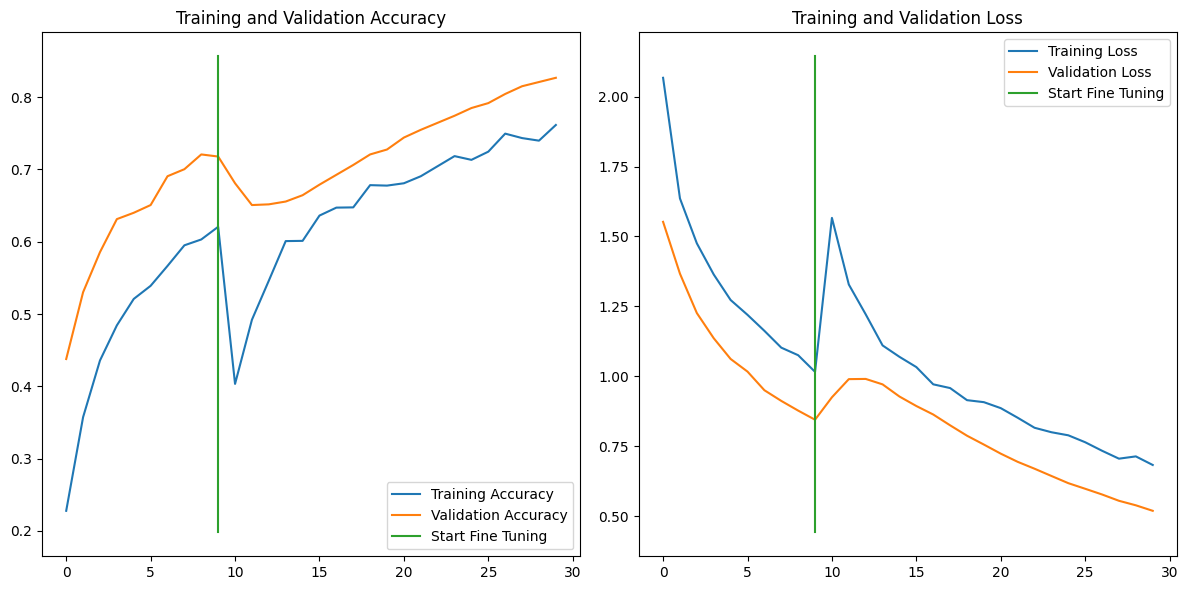

In [16]:
def plot_transfer_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([len(h1.history['accuracy'])-1, len(h1.history['accuracy'])-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([len(h1.history['loss'])-1, len(h1.history['loss'])-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'figures/week2/training_curves_transfer.png'))
    print("✅ Training curves saved.")
plot_transfer_history(history_head, history_fine)

# Evaluation


📊 Evaluating on Test Set...
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.8716 - loss: 0.3689
Test Accuracy: 0.8298
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step

Classification Report:
               precision    recall  f1-score   support

         CaS       0.88      0.90      0.89       160
         CoS       0.87      1.00      0.93       149
         Gum       0.88      0.85      0.86       120
          MC       0.90      0.58      0.71       180
          OC       0.61      0.95      0.74       108
         OLP       0.87      0.74      0.80       180
          OT       0.85      0.89      0.87       131

    accuracy                           0.83      1028
   macro avg       0.84      0.85      0.83      1028
weighted avg       0.85      0.83      0.83      1028

✅ Confusion Matrix saved.


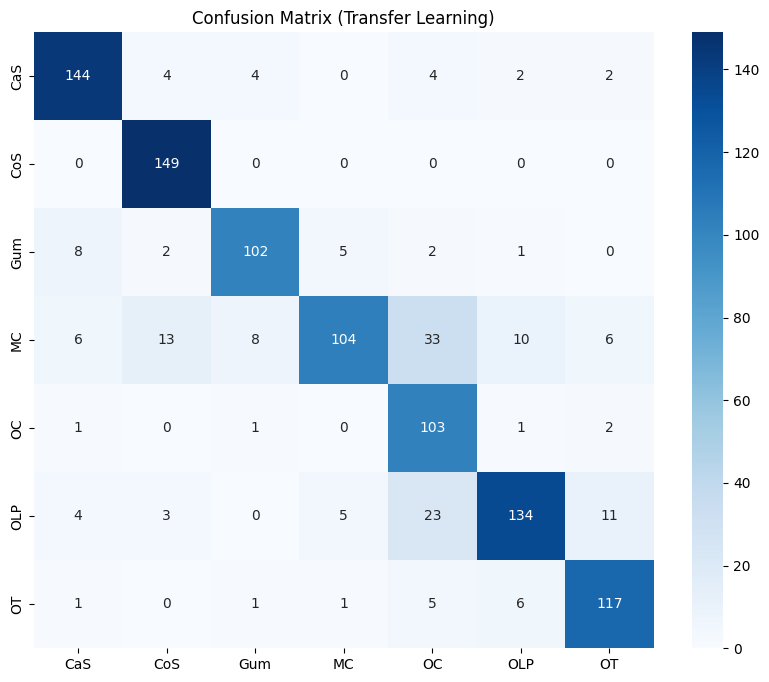

In [17]:
print("\n📊 Evaluating on Test Set...")
best_model = tf.keras.models.load_model(os.path.join(OUTPUT_DIR, 'models/week2/mobilenetv2_best.keras'))
test_loss, test_acc = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")
y_pred_probs = best_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)
with open(os.path.join(OUTPUT_DIR, 'results/week2/classification_report.txt'), 'w') as f:
    f.write(report)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix (Transfer Learning)')
plt.savefig(os.path.join(OUTPUT_DIR, 'figures/week2/confusion_matrix.png'))
print("✅ Confusion Matrix saved.")